In [1]:
import pandas as pd
import numpy as np

# --- 1. Base Models Libraries ---
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# CNN building libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Reshape, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- 2. Meta-Model Library ---
from sklearn.linear_model import LogisticRegression

# --- 3. Helper & EVALUATION Libraries (NEWLY ADDED) ---
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

RANDOM_STATE = 42
N_CLASSES = 7
BOARD_SHAPE = (6, 7, 1) # The board as a 6x7 "image"

!unzip -o "/content/csc462-connect-4.zip" -d "/content/"

print("... Loading data ...")
try:
    train_df = pd.read_csv('train.csv')
    val_df = pd.read_csv('val.csv')
    test_df = pd.read_csv('test.csv')
except FileNotFoundError:
    print("Error: Make sure 'train.csv', 'val.csv', and 'test.csv' are in the same directory.")
    exit()


Archive:  /content/csc462-connect-4.zip
  inflating: /content/sample_submission.csv  
  inflating: /content/test.csv       
  inflating: /content/train.csv      
  inflating: /content/val.csv        
... Loading data ...


In [3]:

# --- Prepare Training Data (from train.csv) ---
X_train = train_df.drop('label_move_col', axis=1)
y_train = train_df['label_move_col']

# --- Prepare Validation Data (from val.csv) ---
X_val = val_df.drop('label_move_col', axis=1)
y_val = val_df['label_move_col'] # This is the "val_y" from your code

# --- Prepare Kaggle Test Data (from test.csv) ---
test_ids = test_df['id']
X_test = test_df.drop('id', axis=1)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")


Training data shape: (49993, 43)
Validation data shape: (10774, 43)
Test data shape: (10868, 43)


In [4]:

# --- Helper function to prepare CNN inputs ---
def prepare_cnn_inputs(data):
    board_data = data.iloc[:, :42].values.reshape(-1, BOARD_SHAPE[0], BOARD_SHAPE[1], BOARD_SHAPE[2])
    turn_data = data.iloc[:, 42].values
    return [board_data, turn_data]

X_train_cnn = prepare_cnn_inputs(X_train)
X_val_cnn = prepare_cnn_inputs(X_val)
X_test_cnn = prepare_cnn_inputs(X_test)



In [5]:
# --- Step 1: Build the CNN Model ---
def create_cnn_model():
    board_input = Input(shape=BOARD_SHAPE, name='board_input')
    conv1 = Conv2D(64, kernel_size=(4, 4), activation='relu', padding='same')(board_input)
    conv2 = Conv2D(128, kernel_size=(4, 4), activation='relu', padding='same')(conv1)
    flat_board = Flatten()(conv2)
    turn_input = Input(shape=(1,), name='turn_input')
    merged = Concatenate()([flat_board, turn_input])
    dense1 = Dense(128, activation='relu')(merged)
    dropout1 = Dropout(0.3)(dense1)
    dense2 = Dense(64, activation='relu')(dropout1)
    output = Dense(N_CLASSES, activation='softmax')(dense2)
    model = Model(inputs=[board_input, turn_input], outputs=output)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print("\n... Building CNN model ...")
model_cnn = create_cnn_model()
model_cnn.summary()



... Building CNN model ...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ board_input         │ (None, 6, 7, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 6, 7, 64)  │      1,088 │ board_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 6, 7, 128) │    131,200 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 5376)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ turn_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5377)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ turn_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    688,384 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7)         │        455 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 829,383 (3.16 MB)

 Trainable params: 829,383 (3.16 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:

# --- Step 2: Define "Tuned" Base Models (RF & XGB) ---

print("\n... Defining Tuned RF & XGB models ...")
model_rf_tuned = RandomForestClassifier(
    n_estimators=300, max_depth=20, min_samples_leaf=5,
    random_state=RANDOM_STATE, n_jobs=-1
)
model_xgb_tuned = XGBClassifier(
    n_estimators=400, max_depth=8, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    objective='multi:softmax', num_class=N_CLASSES,
    random_state=RANDOM_STATE, use_label_encoder=False,
    eval_metric='mlogloss', n_jobs=-1
)



... Defining Tuned RF & XGB models ...


In [7]:

# --- Step 3: Train Base Models (on train.csv) ---

print("\n... Training Base Models (this may take some time) ...")
model_rf_tuned.fit(X_train, y_train)
print("Tuned Random Forest is trained.")
model_xgb_tuned.fit(X_train, y_train)
print("Tuned XGBoost is trained.")

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_cnn.fit(
    X_train_cnn, y_train,
    epochs=50, batch_size=256,
    validation_data=(X_val_cnn, y_val),
    callbacks=[early_stop],
    verbose=0 # Set to 1 if you want to see training progress
)
print("CNN Model is trained.")



... Training Base Models (this may take some time) ...
Tuned Random Forest is trained.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:51:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tuned XGBoost is trained.
CNN Model is trained.


In [8]:

# --- Step 4: Create Meta-Features (from val.csv) ---

print("\n... Creating Meta-Features (from val.csv) ...")
meta_preds_rf = model_rf_tuned.predict_proba(X_val)
meta_preds_xgb = model_xgb_tuned.predict_proba(X_val)
meta_preds_cnn = model_cnn.predict(X_val_cnn)

meta_features = np.concatenate(
    [meta_preds_rf, meta_preds_xgb, meta_preds_cnn],
    axis=1
)
meta_target = y_val
print(f"New meta-features shape: {meta_features.shape}")



... Creating Meta-Features (from val.csv) ...
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
New meta-features shape: (10774, 21)


In [9]:

# --- Step 5: Train the Meta-Model ---

print("\n... Training Meta-Model ...")
meta_model = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE, n_jobs=-1)
meta_model.fit(meta_features, meta_target)
print("Meta-Model (Logistic Regression) is trained.")

# --- Step 6: [TEST] Evaluate Blender Performance ---

print("\n... Testing Blender performance on validation data ...")

# Get the final predictions for the validation set
blender_val_predictions = meta_model.predict(meta_features)




... Training Meta-Model ...
Meta-Model (Logistic Regression) is trained.

... Testing Blender performance on validation data ...


--- Evaluating Advanced Blender on Validation Set ---
 Blender (CNN+XGB+RF) Accuracy: 63.65% 
Blender Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.47      0.49      1450
           1       0.61      0.53      0.57       925
           2       0.62      0.55      0.59      1033
           3       0.72      0.85      0.78      3958
           4       0.62      0.54      0.58      1033
           5       0.62      0.52      0.57       925
           6       0.51      0.49      0.50      1450

    accuracy                           0.64     10774
   macro avg       0.60      0.57      0.58     10774
weighted avg       0.63      0.64      0.63     10774

... Generating Confusion Matrix (New Style) ...


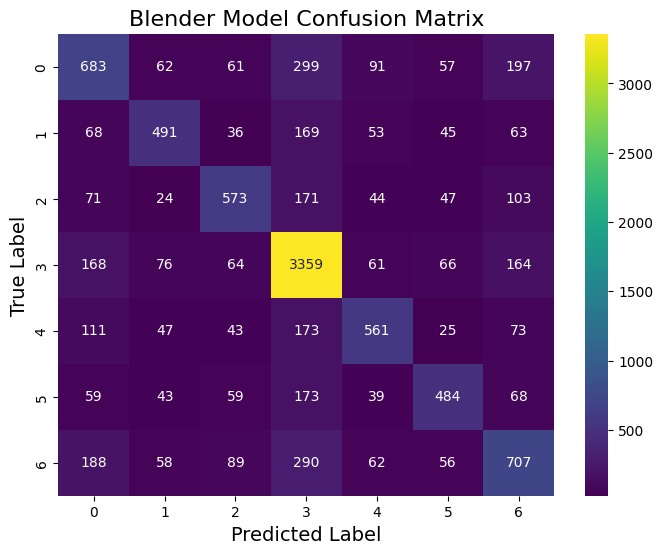

In [11]:
print("--- Evaluating Advanced Blender on Validation Set ---")

# Get the blender's final predictions on the validation set
blender_val_predictions = meta_model.predict(meta_features)

# --- Accuracy ---
blender_accuracy = accuracy_score(meta_target, blender_val_predictions)
print(f" Blender (CNN+XGB+RF) Accuracy: {blender_accuracy * 100:.2f}% ")

# --- Classification Report ---
print("Blender Classification Report:\n")
print(classification_report(meta_target, blender_val_predictions))

# --- Confusion Matrix (NEW STYLE) ---
print("... Generating Confusion Matrix (New Style) ...")
cm = confusion_matrix(meta_target, blender_val_predictions)

plt.figure(figsize=(8, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='viridis',
    xticklabels=range(N_CLASSES),
    yticklabels=range(N_CLASSES)
)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Blender Model Confusion Matrix', fontsize=16)
plt.show()


In [ ]:

# --- Step 7: [FINAL] Predict on Kaggle Test Data (test.csv) ---

print("\n... Generating final submission file ...")

# a. Get base model predictions
test_preds_rf = model_rf_tuned.predict_proba(X_test)
test_preds_xgb = model_xgb_tuned.predict_proba(X_test)
test_preds_cnn = model_cnn.predict(X_test_cnn)

# b. Create test meta-features
test_meta_features = np.concatenate(
    [test_preds_rf, test_preds_xgb, test_preds_cnn],
    axis=1
)

# c. Get final predictions from meta-model
final_predictions = meta_model.predict(test_meta_features)

# d. Save the file
submission_df = pd.DataFrame({
    'id': test_ids,
    'label_move_col': final_predictions
})

submission_df.to_csv('submission_cnn_blend.csv', index=False)
print(f"Successfully created 'submission_cnn_blend.csv'.")